In [1]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkConf
import json
from pyspark import SparkContext,SparkFiles
import numpy as np

In [2]:
#매치정보 합치기

#매치정보
matchDF = spark.read.format("json").load("/sparkdata/PUBG/MatchesList1.json").distinct()
matchDF.printSchema()

matchDF = matchDF.select('id','createdAt','mapName','duration')  \
    .filter((col("isCustomMatch")==False) & (col("matchType")=="competitive"))
            
matchDF.show(5)

root
 |-- createdAt: string (nullable = true)
 |-- duration: long (nullable = true)
 |-- gameMode: string (nullable = true)
 |-- id: string (nullable = true)
 |-- isCustomMatch: boolean (nullable = true)
 |-- mapName: string (nullable = true)
 |-- matchType: string (nullable = true)
 |-- seasonState: string (nullable = true)
 |-- shardId: string (nullable = true)
 |-- stats: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- titleId: string (nullable = true)
 |-- type: string (nullable = true)

+--------------------+--------------------+-----------+--------+
|                  id|           createdAt|    mapName|duration|
+--------------------+--------------------+-----------+--------+
|57dff48b-45a6-4e2...|2022-05-26T01:59:10Z|Baltic_Main|    1844|
|17562fa2-00f7-4dd...|2022-05-15T22:48:17Z|Baltic_Main|    1881|
|33775097-2850-429...|2022-05-20T20:55:55Z| Tiger_Main|    1897|
|ad7decd7-7fb4-405...|2022-05-20T01:36:18Z|Desert_Main|    1692|
|5d3d4b8a-121e-4dd...|2022-05-

In [3]:
#매치 자기장정보
circlePositionDF = spark.read.format("json").load("/sparkdata/PUBG/Matches1_CirclePosition.json").distinct()
circlePositionDF.printSchema()
circlePositionDF.show(5)

root
 |-- blue: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- matchId: string (nullable = true)
 |-- red: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- white: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)

+--------------------+--------------------+--------------------+--------------------+
|                blue|             matchId|                 red|               white|
+--------------------+--------------------+--------------------+--------------------+
|[[0.0, 406387.5, ...|88951693-d6cc-43c...|[[0.0, 0.0, 0.0, ...|[[0.0, 0.0, 0.0, ...|
|[[0.0, 406387.5, ...|7139c667-0799-4f1...|[[0.0, 0.0, 0.0, ...|[[0.0, 0.0, 0.0, ...|
|[[0.0, 406387.5, ...|4fb5d5e5-11cd-4c0...|[[0.0, 0.0, 0.0, ...|[[0.0, 0.0, 0.0, ...|
|[[0.0, 408000.0, ...|0c4c5491-958

In [4]:
#매치 비행기정보
airplaneRouteDF = spark.read.format("json").load("/sparkdata/PUBG/Matches1_AirPlaneRoute.json").distinct()
airplaneRouteDF = airplaneRouteDF.na.drop()
airplaneRouteDF.printSchema()
airplaneRouteDF.show(5)

root
 |-- intercept: double (nullable = true)
 |-- mapX: long (nullable = true)
 |-- matchId: string (nullable = true)
 |-- slope: double (nullable = true)

+------------------+------+--------------------+-------------+
|         intercept|  mapX|             matchId|        slope|
+------------------+------+--------------------+-------------+
|-1033813.819757835|409600|ad8cab68-412a-436...| 9.7036999784|
|  42688.5710657231|204800|d370e4c8-41ab-455...| 0.1880605381|
| -47814.6373893977|819200|f040f45c-c6ce-465...| 1.4857299105|
| 440102.2867084884|819200|591d0213-56f6-4fc...| 0.2204598748|
|-8539082.767434431|819200|a0639006-045e-42c...|21.0765695416|
+------------------+------+--------------------+-------------+
only showing top 5 rows



In [5]:
matchInfoDF = matchDF.join(airplaneRouteDF,matchDF.id==airplaneRouteDF.matchId,"inner") \
    .join(circlePositionDF,matchDF.id==circlePositionDF.matchId,"inner") \
    .select(matchDF.id.alias("matchId"),matchDF.createdAt,matchDF.mapName,matchDF.duration \
            , airplaneRouteDF.mapX.alias("mapSideLength"), airplaneRouteDF.intercept.alias("airplaneRoute_intercept") \
            , airplaneRouteDF.slope.alias("airplaneRoute_slope") \
            , circlePositionDF.blue.alias("blueCircle"),circlePositionDF.white.alias("whiteCircle"))

matchInfoDF.show(10)
matchInfoDF.printSchema()

+--------------------+--------------------+-----------+--------+-------------+-----------------------+-------------------+--------------------+--------------------+
|             matchId|           createdAt|    mapName|duration|mapSideLength|airplaneRoute_intercept|airplaneRoute_slope|          blueCircle|         whiteCircle|
+--------------------+--------------------+-----------+--------+-------------+-----------------------+-------------------+--------------------+--------------------+
|0ae4ee76-e0c2-4bb...|2022-05-23T06:06:32Z|Baltic_Main|    1619|       819200|      611591.9402010179|      -0.5766222533|[[0.0, 406387.5, ...|[[0.0, 0.0, 0.0, ...|
|168bf93d-38af-4aa...|2022-05-16T02:35:26Z|Baltic_Main|    1786|       819200|     1007058.4492530037|      -1.1085319537|[[0.0, 406387.5, ...|[[0.0, 0.0, 0.0, ...|
|3acf4fd9-716f-47c...|2022-05-28T01:25:02Z|Desert_Main|    1739|       819200|     -731698.7205816631|       3.2363852302|[[0.0, 408000.0, ...|[[0.0, 0.0, 0.0, ...|
|4f51f004-

In [6]:
#비행기 기울기 절편에 따른 동선명으로 반환
def airPlaneRouteTrans(data):
    mapSize = data[4]
    blockSize = mapSize/3
    slope = data[6]
    intercept = data[5]
    points = []
    points.append( (int((0-intercept)/slope),0) ) # tuple(x,y)
    points.append( (int(((mapSize/2)-intercept)/slope),mapSize/2) )
    points.append( (int((mapSize-intercept)/slope),mapSize) )
    blockPos = []
    for x, y in points:
        block=0
        if (x >= 0) and (x <= blockSize): #left
            block=1
        elif  x<=blockSize*2 : #middle
            block=2
        else: #right
            block=3
        if (y >= 0) and (y <= blockSize): #up
            block += 0
        elif y<=blockSize*2 : #middle
            block += 3
        else: #down
            block += 6
        blockPos.append(block)
        
    Route = "Don't Know"
    if blockPos[1] == 5:
        Route = "Middle"
    elif (blockPos[0],blockPos[2]) in [(2,8),(8,2),(4,6),(6,4),(1,9),(9,1),(3,7),(7,3)]:
        Route = "Middle"
    elif (blockPos[0],blockPos[2]) in [(1,3),(3,1),(7,9),(9,7),(1,7),(7,1),(3,9),(9,3)]:
        if (blockPos[0],blockPos[2]) in [(1,3),(3,1)]:
            Route = "UpSide"
        elif (blockPos[0],blockPos[2]) in [(7,9),(9,7)]:
            Route = "DownSide"
        elif (blockPos[0],blockPos[2]) in [(1,7),(7,1)]:
            Route = "LeftSide"
        elif (blockPos[0],blockPos[2]) in [(3,9),(9,3)]:
            Route = "RightSide"
    elif (blockPos[0] in [2,8]) or (blockPos[2] in [2,8]):
        if blockPos[1]==4:
            Route = "LeftSide_Middle"
        elif blockPos[1]==6:
            Route = "RightSide_Middle"
        else:
            Route = "Outer"
    return (data[0],data[1],data[2],data[3],data[4],Route,data[7],data[8])

tempRDD = matchInfoDF.rdd.map(airPlaneRouteTrans)
matchInfoDF = tempRDD.toDF(['matchId','createAt','mapName','duration','mapSize',\
                                'airplaneRoute','blueCircle','whiteCircle'])
matchInfoDF.printSchema()

root
 |-- matchId: string (nullable = true)
 |-- createAt: string (nullable = true)
 |-- mapName: string (nullable = true)
 |-- duration: long (nullable = true)
 |-- mapSize: long (nullable = true)
 |-- airplaneRoute: string (nullable = true)
 |-- blueCircle: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- whiteCircle: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)



In [7]:
matchInfoDF.show(20)

+--------------------+--------------------+-----------+--------+-------+----------------+--------------------+--------------------+
|             matchId|            createAt|    mapName|duration|mapSize|   airplaneRoute|          blueCircle|         whiteCircle|
+--------------------+--------------------+-----------+--------+-------+----------------+--------------------+--------------------+
|0ae4ee76-e0c2-4bb...|2022-05-23T06:06:32Z|Baltic_Main|    1619| 819200|          Middle|[[0.0, 406387.5, ...|[[0.0, 0.0, 0.0, ...|
|168bf93d-38af-4aa...|2022-05-16T02:35:26Z|Baltic_Main|    1786| 819200|          Middle|[[0.0, 406387.5, ...|[[0.0, 0.0, 0.0, ...|
|3acf4fd9-716f-47c...|2022-05-28T01:25:02Z|Desert_Main|    1739| 819200|          Middle|[[0.0, 408000.0, ...|[[0.0, 0.0, 0.0, ...|
|4f51f004-d69d-4fe...|2022-05-11T23:40:19Z|Desert_Main|    1794| 819200|          Middle|[[0.0, 408000.0, ...|[[0.0, 0.0, 0.0, ...|
|56901eea-f41e-46d...|2022-05-24T23:04:15Z|Desert_Main|    1655| 819200|    

In [8]:
#비행기 정보 통계
matchInfoDF.groupBy('mapName','airplaneRoute').agg(count('airplaneRoute')).orderBy('mapName').show(50,truncate = False)

+-----------+----------------+--------------------+
|mapName    |airplaneRoute   |count(airplaneRoute)|
+-----------+----------------+--------------------+
|Baltic_Main|LeftSide_Middle |126                 |
|Baltic_Main|Middle          |688                 |
|Baltic_Main|RightSide_Middle|172                 |
|Baltic_Main|RightSide       |1                   |
|Desert_Main|Middle          |676                 |
|Desert_Main|LeftSide_Middle |146                 |
|Desert_Main|RightSide_Middle|143                 |
+-----------+----------------+--------------------+



In [9]:
#플레이어 정보

#플레이어 착지 위치
playerLandingDF = spark.read.format("json").load("/sparkdata/PUBG/Matches1_PlayerLading.json").distinct()
playerLandingDF.show(10)

+--------------------+----------------+-------+--------------------+--------------------+
|             matchId|      playerName|ranking|                   x|                   y|
+--------------------+----------------+-------+--------------------+--------------------+
|b9337288-2cce-4f0...|J-SHOWMETHEMONEY|      6|{null, null, null...|{null, null, null...|
|3afe59b2-cff9-445...|       KR-LIZARD|      2|{null, null, null...|{null, null, null...|
|a2235a57-195d-470...|        BZG_OSAL|     12|{null, null, null...|{null, null, null...|
|a2235a57-195d-470...|       AMG_JIANT|      5|{null, null, null...|{null, null, null...|
|8a36f768-2c8b-4b7...|      KOR_JS3778|     12|{null, null, null...|{null, null, null...|
|a4bc5e6c-f1f1-452...|     Hyein2da-_-|     11|{null, null, null...|{null, null, null...|
|475c964d-c67d-4be...|  SwankyPantsGod|      2|{null, null, null...|{null, null, null...|
|92d7fcdd-9cf5-42f...|         DC_Rome|      6|{null, null, null...|{null, null, null...|
|6e5514ba-

In [10]:
def findPos(data):
    Pos=0
    for value in data:
        if not value == None:
            Pos = value
    return Pos

convertUDF = udf(lambda x:findPos(x),DoubleType())

playerLandingDF = playerLandingDF.select(col('matchId'),col('playerName'),col('ranking'),convertUDF(col('x')).alias('xPos')\
                                         ,convertUDF(col('y')).alias('yPos')).distinct()
playerLandingDF.printSchema()
playerLandingDF.show(10)

root
 |-- matchId: string (nullable = true)
 |-- playerName: string (nullable = true)
 |-- ranking: long (nullable = true)
 |-- xPos: double (nullable = true)
 |-- yPos: double (nullable = true)

+--------------------+----------------+-------+-------------+------------+
|             matchId|      playerName|ranking|         xPos|        yPos|
+--------------------+----------------+-------+-------------+------------+
|b9337288-2cce-4f0...|J-SHOWMETHEMONEY|      6|   458143.875| 626564.0625|
|3afe59b2-cff9-445...|       KR-LIZARD|      2|    399246.25|487224.71875|
|a2235a57-195d-470...|        BZG_OSAL|     12|   301561.125|430548.53125|
|a2235a57-195d-470...|       AMG_JIANT|      5|71759.5859375| 456179.3125|
|8a36f768-2c8b-4b7...|      KOR_JS3778|     12|  643030.8125|245492.71875|
|a4bc5e6c-f1f1-452...|     Hyein2da-_-|     11|212831.734375| 272995.9375|
|475c964d-c67d-4be...|  SwankyPantsGod|      2| 437845.71875|278797.65625|
|92d7fcdd-9cf5-42f...|         DC_Rome|      6|  58671

In [11]:
playerLandingDF = playerLandingDF.join(matchInfoDF, playerLandingDF['matchId']==matchInfoDF['matchId'],'inner')\
            .select(matchInfoDF['matchId'], matchInfoDF['mapName'], playerLandingDF['ranking'] \
             ,playerLandingDF['playerName'], playerLandingDF['xPos'], playerLandingDF['yPos']).na.drop()
playerLandingDF.show(10)

+--------------------+-----------+-------+--------------+------------+-------------+
|             matchId|    mapName|ranking|    playerName|        xPos|         yPos|
+--------------------+-----------+-------+--------------+------------+-------------+
|0ae4ee76-e0c2-4bb...|Baltic_Main|     11| Fiesta_Taeseo|   618125.25|     612138.5|
|0ae4ee76-e0c2-4bb...|Baltic_Main|      3|Valentino_TANK| 450529.0625| 315106.40625|
|0ae4ee76-e0c2-4bb...|Baltic_Main|     16|        JJ6469| 579842.6875| 485966.03125|
|0ae4ee76-e0c2-4bb...|Baltic_Main|      4|   MAYBACHSAJO|155383.96875| 276704.84375|
|0ae4ee76-e0c2-4bb...|Baltic_Main|      7|   joonhee0820| 599804.3125| 481784.90625|
|0ae4ee76-e0c2-4bb...|Baltic_Main|     10|         Ya_TV| 361404.8125| 514392.90625|
|0ae4ee76-e0c2-4bb...|Baltic_Main|      3|      Le-mario|450773.90625|    314778.75|
|0ae4ee76-e0c2-4bb...|Baltic_Main|     13|  LeeyongZOO12| 361271.6875| 296037.40625|
|0ae4ee76-e0c2-4bb...|Baltic_Main|      9|     14K-Dyson|    3721

In [12]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
#폴리곤정보 불러오기
ErangelPolygon = json.load(open("Erangel_LocalPos_Polygon.json"))
ErangelArea = dict()
for name,pos in ErangelPolygon.items():
    pos = (np.array(pos)*100).tolist()
    ErangelArea[name]=Polygon(pos)
    
MiramarPolygon = json.load(open("Miramar_LocalPos_Polygon.json"))
MiramarArea = dict()
for name,pos in MiramarPolygon.items():
    pos = (np.array(pos)*100).tolist()
    MiramarArea[name]=Polygon(pos)

#폴리곤정보로 명칭 변경
tempDF = playerLandingDF.collect()
tempData = []
for data in tempDF:
    localName = 'another'
    mapName = data[1]
    if mapName == 'Baltic_Main':
        for name,polygon in ErangelArea.items():
            if polygon.contains(Point(data[4],data[5])):
                localName = name
    elif mapName == 'Desert_Main':
        for name,polygon in MiramarArea.items():
            if polygon.contains(Point(data[4],data[5])):
                localName = name
    tempData.append((data[0],data[1],data[2],data[3],localName))

playerLandingDF = spark.createDataFrame(tempData,['matchId','mapName','ranking','playerName','landingPlace'])
playerLandingDF.show(10)

+--------------------+-----------+-------+--------------+-------------------+
|             matchId|    mapName|ranking|    playerName|       landingPlace|
+--------------------+-----------+-------+--------------+-------------------+
|0ae4ee76-e0c2-4bb...|Baltic_Main|     11| Fiesta_Taeseo|        Novorepnoye|
|0ae4ee76-e0c2-4bb...|Baltic_Main|      3|Valentino_TANK|            another|
|0ae4ee76-e0c2-4bb...|Baltic_Main|     16|        JJ6469|              Mylta|
|0ae4ee76-e0c2-4bb...|Baltic_Main|      4|   MAYBACHSAJO|    Georgopol_south|
|0ae4ee76-e0c2-4bb...|Baltic_Main|      7|   joonhee0820|              Mylta|
|0ae4ee76-e0c2-4bb...|Baltic_Main|     10|         Ya_TV|      MiddleVillage|
|0ae4ee76-e0c2-4bb...|Baltic_Main|      3|      Le-mario|MiddleBridgeVillage|
|0ae4ee76-e0c2-4bb...|Baltic_Main|     13|  LeeyongZOO12|           AquaCity|
|0ae4ee76-e0c2-4bb...|Baltic_Main|      9|     14K-Dyson|           Pochinki|
|0ae4ee76-e0c2-4bb...|Baltic_Main|      1|        hosiss|    Geo

In [13]:
#플레이어 동선
playerPositionDF = spark.read.format('json').load("/sparkdata/PUBG/Matches1_PlayerPosition_Baltic_Main.json").distinct()
playerPositionDF.show(10)

+--------------------+----------------+--------------------+-------+
|             matchId|      playerName|            position|ranking|
+--------------------+----------------+--------------------+-------+
|21bf1ec8-4ee8-434...|          ATS_SY|[[5.481, 295967.6...|     14|
|b4fc5a91-a416-40c...|         NBG_xXx|[[1.649, 161841.7...|     14|
|b811ba90-7327-4d8...|       BoB_5king|[[2.754, 939804.0...|     16|
|e808b51a-881b-49a...|     Redsox_jjun|[[9.415, 187888.5...|      1|
|376564f4-b798-4b8...|       qjhwhwehq|[[8.677, 298904.6...|      5|
|75e31315-936e-48f...|         HB_SOSO|[[4.234, 914450.4...|     15|
|75e31315-936e-48f...|      WG_lliliil|[[5.939, 890111.4...|     10|
|e205544b-ae69-492...|OcO_Uncle_BongTV|[[2.052, 462802.5...|     12|
|e205544b-ae69-492...|  Kings_benjamin|[[2.286, 463071.6...|      7|
|3769da96-c4f0-4ae...|       bjRungRan|[[8.13, 795046.93...|     10|
+--------------------+----------------+--------------------+-------+
only showing top 10 rows



In [14]:
playerPositionDF.printSchema()
matchInfoDF.printSchema()

root
 |-- matchId: string (nullable = true)
 |-- playerName: string (nullable = true)
 |-- position: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- ranking: long (nullable = true)

root
 |-- matchId: string (nullable = true)
 |-- createAt: string (nullable = true)
 |-- mapName: string (nullable = true)
 |-- duration: long (nullable = true)
 |-- mapSize: long (nullable = true)
 |-- airplaneRoute: string (nullable = true)
 |-- blueCircle: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- whiteCircle: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)



In [15]:
#자기장과 비교를 위해 조인연산
tempDF = playerPositionDF.alias('Pos').join(matchInfoDF.alias('Matches') \
             ,playerPositionDF['matchId']==matchInfoDF['matchId'],'inner')  \
             .select('Matches.matchId','Matches.mapName','Matches.duration','Matches.blueCircle','Matches.whiteCircle'\
             ,'Pos.playerName','Pos.ranking','Pos.position')

tempDF.printSchema()

root
 |-- matchId: string (nullable = true)
 |-- mapName: string (nullable = true)
 |-- duration: long (nullable = true)
 |-- blueCircle: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- whiteCircle: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- playerName: string (nullable = true)
 |-- ranking: long (nullable = true)
 |-- position: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)



In [16]:
#총 이동거리로 변환
def DistancePlayer(position):
    import builtins
    round = getattr(builtins, "round")
    abs = getattr(builtins, "abs")
    moveDistance = 0
    liveTime = 0
    if len(position)!=0:
        liveTime = position[-1][0]
    for idx, pos in enumerate(position[1:]):
        x2,y2 = pos[1],pos[2]
        x1,y1 = position[idx][1],position[idx][2]
        moveDistance += ((abs(x2-x1)**2)+(abs(y2-y1)**2))**(1/2) / 102.4
    moveDistance = round(moveDistance,10)
    return moveDistance, liveTime

In [17]:
#자기장과의 거리 값으로 변환
def DistancePlayerAndCircle(blueCircle,whiteCircle,position):  
    WhiteDistance = []
    BlueDistance = []

    weight = 0.7
    cnt=0
    for pos in position:
        Ptime = pos[0]
        timecheck=0
        for point, Ctime in enumerate([tm[0] for tm in whiteCircle]):
            if Ptime < Ctime:
                timecheck = point
                break
                
        posX = pos[1]
        posY = pos[2]
        
        if ((cnt%18 == 0) & (cnt!=0)):
            weight *=0.7
        
        WcircleX = whiteCircle[point][1]
        WcircleY = whiteCircle[point][2]
        WcircleR = whiteCircle[point][4]
        
        import builtins
        abs = getattr(builtins, "abs") #내장함수abs와 spark.abs 덮어씌우기
        round = getattr(builtins, "round")
        
        BcircleX = blueCircle[point][1]
        BcircleY = blueCircle[point][2]
        BcircleR = blueCircle[point][4]
        
        BDistance = (BcircleR - ((abs(BcircleX-posX)**2)+(abs(BcircleY-posY)**2))**(1/2))/BcircleR
        BlueDistance.append( (Ptime, round(BDistance * (1-weight),10)) )
        
        if not WcircleR == 0:
            WDistance = ((abs(WcircleX-posX)**2)+(abs(WcircleY-posY)**2))**(1/2) / BcircleR
            WhiteDistance.append( (Ptime,round(WDistance * (1-weight),10)) ) #T
        cnt+=1
        
    return WhiteDistance, BlueDistance


In [18]:
def summaryDistance(data):
    matchId = data[0]
    mapName = data[1]
    duration = data[2]
    blueCircle = data[3]
    whiteCircle = data[4]
    playerName = data[5]
    ranking = data[6]
    position = data[7]
    moveDistance, liveTime = DistancePlayer(position)
    WhiteDistance, BlueDistance = DistancePlayerAndCircle(blueCircle,whiteCircle,position)
    
    return matchId, mapName, duration, playerName, ranking, liveTime, moveDistance, WhiteDistance, BlueDistance

tempRDD = tempDF.rdd.map(summaryDistance)
playerDistanceDF = tempRDD.toDF(['matchId','mapName','duration','playerName' \
                             ,'ranking','liveTime','moveDistance','WhiteCircleDistance','BlueCircleDistance'])
playerDistanceDF.show(10)

+--------------------+-----------+--------+----------------+-------+--------+----------------+--------------------+--------------------+
|             matchId|    mapName|duration|      playerName|ranking|liveTime|    moveDistance| WhiteCircleDistance|  BlueCircleDistance|
+--------------------+-----------+--------+----------------+-------+--------+----------------+--------------------+--------------------+
|0ae4ee76-e0c2-4bb...|Baltic_Main|    1619|       14K-Dyson|      9|1160.667| 9643.2292407632|[{80.681, 0.15152...|[{0.651, 0.007199...|
|0ae4ee76-e0c2-4bb...|Baltic_Main|    1619|         14K-nok|      9|1162.703|  9905.721689735|[{82.718, 0.17537...|[{2.722, 0.022547...|
|0ae4ee76-e0c2-4bb...|Baltic_Main|    1619|    SeungHyeon-e|      5|1444.304|12279.7280191351|[{84.322, 0.06781...|[{4.292, 0.034180...|
|0ae4ee76-e0c2-4bb...|Baltic_Main|    1619|         102beom|     11| 746.447|11021.4325406113|[{86.426, 0.09629...|[{6.429, 0.050018...|
|0ae4ee76-e0c2-4bb...|Baltic_Main|    161

In [19]:
#공격 로그
AttackDF = spark.read.format('json').load("/sparkdata/PUBG/Matches1_AttackerList.json")
AttackDF.printSchema()
AttackDF.show(10)

root
 |-- a_x: double (nullable = true)
 |-- a_y: double (nullable = true)
 |-- a_z: double (nullable = true)
 |-- attacker: string (nullable = true)
 |-- matchId: string (nullable = true)
 |-- time: double (nullable = true)
 |-- v_x: double (nullable = true)
 |-- v_y: double (nullable = true)
 |-- v_z: double (nullable = true)

+------------+-----------+-------------+--------+--------------------+------+------------+-----------+-------------+
|         a_x|        a_y|          a_z|attacker|             matchId|  time|         v_x|        v_y|          v_z|
+------------+-----------+-------------+--------+--------------------+------+------------+-----------+-------------+
|416962.09375|   668838.0|51.2099990845|  SMO1KE|ffff5561-157c-401...| 2.602|429306.59375|665495.5625|79.2099990845|
|416962.09375|   668838.0|51.2099990845|  SMO1KE|ffff5561-157c-401...| 3.804| 429277.6875|665477.1875|79.2099990845|
|416962.09375|   668838.0|51.2099990845|  SMO1KE|ffff5561-157c-401...|  6.31|428915.

In [20]:
#매치자기장 정보와 공격정보 묶기
tempDF = AttackDF.distinct().alias('Atk').join(matchInfoDF.alias('MI') \
             ,AttackDF['matchId']==matchInfoDF['matchId'],'inner') \
             .select('MI.matchId','MI.mapName','MI.blueCircle','Atk.attacker' \
             ,'Atk.a_x','Atk.a_y','Atk.a_z','Atk.v_x','Atk.v_y','Atk.v_z','Atk.time')
tempDF.show(10)

+--------------------+-----------+--------------------+----------------+-----------+------------+---------------+-----------+------------+---------------+--------+
|             matchId|    mapName|          blueCircle|        attacker|        a_x|         a_y|            a_z|        v_x|         v_y|            v_z|    time|
+--------------------+-----------+--------------------+----------------+-----------+------------+---------------+-----------+------------+---------------+--------+
|0ae4ee76-e0c2-4bb...|Baltic_Main|[[0.0, 406387.5, ...|     BITION_WAY_|591086.8125|480069.15625| 877.0399780273|585231.3125| 464668.6875|1747.0200195312| 358.716|
|0ae4ee76-e0c2-4bb...|Baltic_Main|[[0.0, 406387.5, ...|        zzzz-ppp|568487.4375|  374673.875|2249.0900878906|  570208.25| 375674.1875|2177.6799316406| 967.834|
|0ae4ee76-e0c2-4bb...|Baltic_Main|[[0.0, 406387.5, ...|          AMF_8x|628414.0625| 343200.4375| 406.5799865723|634305.9375|  343106.625|          377.0|1387.552|
|0ae4ee76-e0c2-4

In [21]:
def combatDistance(a_x,a_y,a_z,v_x,v_y,v_z):
    import builtins
    round = getattr(builtins, "round")
    abs = getattr(builtins, "abs")
    Distance_xy = ((abs(a_x-v_x)**2)+(abs(a_y-v_y)**2))**(1/2)
    Distance_xyz = ((Distance_xy**2)+(abs(a_z-v_z)**2))**(1/2)
    Distance_meter = Distance_xyz/102.4
    return round(Distance_meter,3)

In [22]:
def combatPosition(time,blueCircle,a_x,a_y): 
    import builtins
    abs = getattr(builtins, "abs")
    position = []
    for idx, timeLine in enumerate(blueCircle):
        if idx < len(blueCircle):
            if (timeLine[0] < time) | (blueCircle[idx+1][0] >= time):#사이값
                b_x = timeLine[1]
                b_y = timeLine[2]
                b_r = timeLine[4]
                position = ((abs(b_x-a_x)**2)+(abs(b_y-a_y)**2))**(1/2)/102.4
                break
        else:#마지막
            b_x = timeLine[1]
            b_y = timeLine[2]
            b_r = timeLine[3]
            position = ((abs(b_x-a_x)**2)+(abs(b_y-a_y)**2))**(1/2)/102.4
            break
    return position

In [23]:
def summaryCombat(data):
    matchId = data[0]
    mapName = data[1]
    blueCircle = data[2]
    attacker = data[3]
    time = data[10]
    a_x = data[4]
    a_y = data[5]
    a_z = data[6] 
    v_x = data[7]
    v_y = data[8]
    v_z = data[9]
    distance = combatDistance(a_x,a_y,a_z,v_x,v_y,v_z)
    position = combatPosition(time,blueCircle,a_x,a_y)
    return matchId, mapName, attacker, time, distance, position

tempRDD = tempDF.rdd.map(summaryCombat)
playerCombatDF = tempRDD.toDF(['matchId','mapName','playerName' \
                             ,'attackTime','attackDistance','BlueCircleDistance'])
playerCombatDF.show(10)

+--------------------+-----------+----------------+----------+--------------+------------------+
|             matchId|    mapName|      playerName|attackTime|attackDistance|BlueCircleDistance|
+--------------------+-----------+----------------+----------+--------------+------------------+
|0ae4ee76-e0c2-4bb...|Baltic_Main|     BITION_WAY_|   358.716|       161.123|1941.9313639238696|
|0ae4ee76-e0c2-4bb...|Baltic_Main|        zzzz-ppp|   967.834|         19.45|1613.0182822618217|
|0ae4ee76-e0c2-4bb...|Baltic_Main|          AMF_8x|  1387.552|        57.546|2254.3242401370117|
|0ae4ee76-e0c2-4bb...|Baltic_Main|     sexybboy-0-|   427.935|        38.542|1978.1351003129334|
|0ae4ee76-e0c2-4bb...|Baltic_Main|Valentino_Golden|  1069.881|       224.765|2383.2146516242196|
|0ae4ee76-e0c2-4bb...|Baltic_Main|            P2ge|   674.796|         8.731| 2472.806242356927|
|0ae4ee76-e0c2-4bb...|Baltic_Main|        Smdht-EL|  1429.934|        162.06|2482.0401341826673|
|0ae4ee76-e0c2-4bb...|Baltic_M

In [24]:
#공격자에 대해서 공격정보 묶기 (ReduceByKey 사용)
tempRDD = playerCombatDF.orderBy('attackTime') \
                        .rdd.map(lambda row : ((row[0],row[1],row[2]),[(row[3],row[4],row[5])])) \
                            .reduceByKey(lambda x,y: x+y) \
                            .map(lambda row : (row[0][0],row[0][1],row[0][2],row[1]))
playerCombatDF = tempRDD.toDF(['matchId','mapName','playerName','attacks'])

In [25]:
playerCombatDF.show(20)

+--------------------+-----------+----------------+--------------------+
|             matchId|    mapName|      playerName|             attacks|
+--------------------+-----------+----------------+--------------------+
|a59d0f0c-8ec7-4e0...|Desert_Main|       Terranix-|[{72.18, 59.71, 3...|
|7e01490f-b140-402...|Baltic_Main|       952949629|[{72.391, 43.221,...|
|d198bd1c-845f-433...|Desert_Main|      9_ZAMMANBO|[{76.334, 4.885, ...|
|217863e4-77b0-404...|Desert_Main|Military12Driver|[{76.741, 39.904,...|
|5ed97409-1dba-4c3...|Desert_Main|   184cm85kg20cm|[{84.505, 113.058...|
|1f50b081-77f1-407...|Desert_Main|         e_motap|[{98.227, 18.507,...|
|83abdae4-3bd7-4db...|Baltic_Main|      LimBBaHong|[{98.292, 4.177, ...|
|cab7f48c-651f-48b...|Baltic_Main|       WG_Inonix|[{99.298, 3.588, ...|
|da708bec-63eb-4bd...|Baltic_Main|       Merong_HN|[{100.927, 59.435...|
|79ba6c30-0ae4-48f...|Desert_Main|      CVT_Salido|[{101.986, 3.603,...|
|0bd0fd7e-617e-48e...|Baltic_Main|TBU_Twitch_SP4RK|

In [26]:
#차량탑승 로그
rideVehicleDF = spark.read.format('json').load("/sparkdata/PUBG/Matches1_RideVehicle.json")
rideVehicleDF.printSchema()
rideVehicleDF.show(10)

root
 |-- matchId: string (nullable = true)
 |-- player: string (nullable = true)
 |-- time: string (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)

+--------------------+--------------+--------------------+-------------+-------------+---------------+
|             matchId|        player|                time|            x|            y|              z|
+--------------------+--------------+--------------------+-------------+-------------+---------------+
|b9337288-2cce-4f0...|     K_JooHong|2022-05-14T14:18:...| 433253.84375| 467092.46875|2095.7080078125|
|b9337288-2cce-4f0...|What9Sangman_2|2022-05-14T14:18:...|     427737.0|    327429.25| 784.8502197266|
|b9337288-2cce-4f0...|    kim_seulki|2022-05-14T14:18:...| 408346.34375| 346234.53125| 208.9286804199|
|b9337288-2cce-4f0...|     K_JooHong|2022-05-14T14:18:...|  416194.9375|   476328.125|3009.9797363281|
|b9337288-2cce-4f0...|      BLOODC0W|2022-05-14T14:18:...| 27

In [27]:
tempDF = rideVehicleDF.alias('RV').join(matchInfoDF.alias('MI') \
             ,rideVehicleDF['matchId']==matchInfoDF['matchId'],'inner')  \
             .select('RV.matchId','MI.mapName',col('RV.player').alias('playerName'),'MI.createAt'\
             ,'RV.time')
tempDF.printSchema()
tempDF.show(5)

root
 |-- matchId: string (nullable = true)
 |-- mapName: string (nullable = true)
 |-- playerName: string (nullable = true)
 |-- createAt: string (nullable = true)
 |-- time: string (nullable = true)

+--------------------+-----------+----------+--------------------+--------------------+
|             matchId|    mapName|playerName|            createAt|                time|
+--------------------+-----------+----------+--------------------+--------------------+
|0ae4ee76-e0c2-4bb...|Baltic_Main|    AMF_6x|2022-05-23T06:06:32Z|2022-05-23T06:07:...|
|0ae4ee76-e0c2-4bb...|Baltic_Main|   14K-nok|2022-05-23T06:06:32Z|2022-05-23T06:07:...|
|0ae4ee76-e0c2-4bb...|Baltic_Main|   14K-nok|2022-05-23T06:06:32Z|2022-05-23T06:07:...|
|0ae4ee76-e0c2-4bb...|Baltic_Main|    AMF_6x|2022-05-23T06:06:32Z|2022-05-23T06:07:...|
|0ae4ee76-e0c2-4bb...|Baltic_Main|Limbinlord|2022-05-23T06:06:32Z|2022-05-23T06:07:...|
+--------------------+-----------+----------+--------------------+--------------------+
only s

In [28]:
def timeSet(data): 
    import re
    import builtins
    sum = getattr(builtins, "sum")
    createAt=re.compile('T[0-9]{2}:[0-9]{2}:[0-9]{2}Z').findall(data[3])
    playTime=re.compile('T[0-9]{2}:[0-9]{2}:[0-9]{2}[.]').findall(data[4])
    (createHour,createMin,createSec) = re.findall("[0-9]{2}",createAt[0])
    (playHour,playMin,playSec) = re.findall("[0-9]{2}",playTime[0])
    Sec = int(playSec) - int(createSec)
    Min = int(playMin) - int(createMin)
    Hour = int(playHour) - int(createHour)
    #년도날짜요일에 대해서는 빼기 때문에 음수에 대해서 올림처리
    if Sec < 0:
        Sec = 60+Sec
        Min -=1
    if Min < 0:
        Min = 60+Min
        Hour -=1
    if Hour < 0:
        Hour = 24+Hour
        
    time = (Hour*3600)+(Min*60)+Sec
             
    return (data[0],data[1],data[2],time)


tempRDD = tempDF.rdd.map(timeSet)
rideVehicleTimeDF = tempRDD.toDF(['matchId','mapName','playerName','rideTime'])
rideVehicleTimeDF.show(10)

+--------------------+-----------+----------------+--------+
|             matchId|    mapName|      playerName|rideTime|
+--------------------+-----------+----------------+--------+
|0ae4ee76-e0c2-4bb...|Baltic_Main|          AMF_6x|      70|
|0ae4ee76-e0c2-4bb...|Baltic_Main|         14K-nok|      71|
|0ae4ee76-e0c2-4bb...|Baltic_Main|         14K-nok|      71|
|0ae4ee76-e0c2-4bb...|Baltic_Main|          AMF_6x|      86|
|0ae4ee76-e0c2-4bb...|Baltic_Main|      Limbinlord|      86|
|0ae4ee76-e0c2-4bb...|Baltic_Main|      Limbinlord|      86|
|0ae4ee76-e0c2-4bb...|Baltic_Main|  Valentino_TANK|      87|
|0ae4ee76-e0c2-4bb...|Baltic_Main|     Dark_B_Plar|      88|
|0ae4ee76-e0c2-4bb...|Baltic_Main|Valentino_Golden|      89|
|0ae4ee76-e0c2-4bb...|Baltic_Main|     itzy3_3yeji|      93|
+--------------------+-----------+----------------+--------+
only showing top 10 rows



In [29]:
#차량하차 로그
leaveVehicleDF = spark.read.format('json').load("/sparkdata/PUBG/Matches1_LeaveVehicle.json")
leaveVehicleDF.printSchema()
leaveVehicleDF.show(10)

root
 |-- matchId: string (nullable = true)
 |-- player: string (nullable = true)
 |-- time: string (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)

+--------------------+--------------+--------------------+-------------+-------------+---------------+
|             matchId|        player|                time|            x|            y|              z|
+--------------------+--------------+--------------------+-------------+-------------+---------------+
|b9337288-2cce-4f0...|     K_JooHong|2022-05-14T14:18:...| 416240.78125| 476396.96875|3011.7536621094|
|b9337288-2cce-4f0...|     K_JooHong|2022-05-14T14:18:...| 416124.15625|     476366.0|3010.1247558594|
|b9337288-2cce-4f0...|      BLOODC0W|2022-05-14T14:18:...| 271604.09375|  428083.5625| 608.6817626953|
|b9337288-2cce-4f0...|What9Sangman_2|2022-05-14T14:18:...|  434366.0625|   327110.125| 302.6544189453|
|b9337288-2cce-4f0...|     Hwan-2-DA|2022-05-14T14:18:...| 35

In [30]:
tempDF = leaveVehicleDF.alias('LV').join(matchInfoDF.alias('MI') \
             ,leaveVehicleDF['matchId']==matchInfoDF['matchId'],'inner')  \
             .select('LV.matchId','MI.mapName',col('LV.player').alias('playerName'),'MI.createAt'\
             ,'LV.time')
tempDF.printSchema()
tempDF.show(5)

root
 |-- matchId: string (nullable = true)
 |-- mapName: string (nullable = true)
 |-- playerName: string (nullable = true)
 |-- createAt: string (nullable = true)
 |-- time: string (nullable = true)

+--------------------+-----------+----------+--------------------+--------------------+
|             matchId|    mapName|playerName|            createAt|                time|
+--------------------+-----------+----------+--------------------+--------------------+
|0ae4ee76-e0c2-4bb...|Baltic_Main|   14K-nok|2022-05-23T06:06:32Z|2022-05-23T06:07:...|
|0ae4ee76-e0c2-4bb...|Baltic_Main|   14K-nok|2022-05-23T06:06:32Z|2022-05-23T06:07:...|
|0ae4ee76-e0c2-4bb...|Baltic_Main|    AMF_6x|2022-05-23T06:06:32Z|2022-05-23T06:07:...|
|0ae4ee76-e0c2-4bb...|Baltic_Main|    AMF_6x|2022-05-23T06:06:32Z|2022-05-23T06:07:...|
|0ae4ee76-e0c2-4bb...|Baltic_Main|Limbinlord|2022-05-23T06:06:32Z|2022-05-23T06:07:...|
+--------------------+-----------+----------+--------------------+--------------------+
only s

In [31]:
tempRDD = tempDF.rdd.map(timeSet)
leaveVehicleTimeDF = tempRDD.toDF(['matchId','mapName','playerName','leaveTime'])
leaveVehicleTimeDF.show(10)

+--------------------+-----------+--------------+---------+
|             matchId|    mapName|    playerName|leaveTime|
+--------------------+-----------+--------------+---------+
|0ae4ee76-e0c2-4bb...|Baltic_Main|       14K-nok|       71|
|0ae4ee76-e0c2-4bb...|Baltic_Main|       14K-nok|       85|
|0ae4ee76-e0c2-4bb...|Baltic_Main|        AMF_6x|       86|
|0ae4ee76-e0c2-4bb...|Baltic_Main|        AMF_6x|       86|
|0ae4ee76-e0c2-4bb...|Baltic_Main|    Limbinlord|       86|
|0ae4ee76-e0c2-4bb...|Baltic_Main|Valentino_TANK|       90|
|0ae4ee76-e0c2-4bb...|Baltic_Main|        4x_777|       97|
|0ae4ee76-e0c2-4bb...|Baltic_Main|   Dark_B_Plar|       99|
|0ae4ee76-e0c2-4bb...|Baltic_Main|      Le-mario|      103|
|0ae4ee76-e0c2-4bb...|Baltic_Main|     Raebuk_TV|      106|
+--------------------+-----------+--------------+---------+
only showing top 10 rows



In [32]:
playerVehicleRideDF = rideVehicleTimeDF.groupBy('matchId','mapName','playerName') \
                                        .agg(min('rideTime').alias('firstRideTime'))
playerVehicleLeaveDF = leaveVehicleTimeDF.groupBy('matchId','mapName','playerName') \
                                        .agg(max('leaveTime').alias('lastLeaveTime'))
playerVehicleDF = playerVehicleRideDF.alias('RV').join(playerVehicleLeaveDF.alias('LV') \
                                    ,((playerVehicleRideDF['matchID']==playerVehicleLeaveDF['matchID']) \
                                      &(playerVehicleRideDF['mapName']==playerVehicleLeaveDF['mapName'])
                                      &(playerVehicleRideDF['playerName']==playerVehicleLeaveDF['playerName'])),'inner') \
                                    .select('RV.matchId','RV.mapName','RV.playerName' \
                                            ,'RV.firstRideTime','LV.lastLeaveTime')
playerVehicleDF.show(10)

+--------------------+-----------+-------------+-------------+-------------+
|             matchId|    mapName|   playerName|firstRideTime|lastLeaveTime|
+--------------------+-----------+-------------+-------------+-------------+
|00e2d5bb-8e71-41c...|Desert_Main|       Min2EU|          269|         1367|
|00ecb0ca-a5ad-47a...|Desert_Main|  NaeClanMas-|          221|          867|
|00f22211-7314-484...|Baltic_Main|     RX_3Some|           88|          511|
|00f22211-7314-484...|Baltic_Main|  SPY_Veteran|          334|         1447|
|018ae528-093c-45f...|Baltic_Main|     AFTV_VEX|          234|         1016|
|02ad1d03-defb-47c...|Baltic_Main|     DaLgee_x|          311|         1282|
|03c8286a-1023-48c...|Baltic_Main|  MaSitDDa-_-|          104|          313|
|03ca49bb-2293-430...|Desert_Main|     RAON_BIN|          162|         1218|
|04b0c144-2937-441...|Baltic_Main|Doomscrolling|          549|          808|
|04b0c144-2937-441...|Baltic_Main|     leriodn2|          447|         1142|

In [33]:
matchPlayerDF = playerLandingDF.alias('F').join(playerDistanceDF.alias('S') \
                                    ,((playerLandingDF['matchId']==playerDistanceDF['matchId']) \
                                      &(playerLandingDF['mapName']==playerDistanceDF['mapName']) \
                                      &(playerLandingDF['playerName']==playerDistanceDF['playerName'])),'inner') \
                            .select('F.matchId','F.mapName','F.playerName','F.ranking','S.liveTime' \
                            ,'F.landingPlace','S.moveDistance','S.WhiteCircleDistance','S.BlueCircleDistance').alias('F') \
                                    .join(playerCombatDF.alias('S') \
                                    ,((col('F.matchId')==playerCombatDF['matchId']) \
                                      &(col('F.mapName')==playerCombatDF['mapName']) \
                                      &(col('F.playerName')==playerCombatDF['playerName'])),'leftouter') \
                            .select('F.*','S.attacks').alias('F').join(playerVehicleDF.alias('S') \
                                    ,((col('F.matchId')==playerVehicleDF['matchId']) \
                                      &(col('F.mapName')==playerVehicleDF['mapName']) \
                                      &(col('F.playerName')==playerVehicleDF['playerName'])),'leftouter') \
                            .select('F.*','S.firstRideTime','S.lastLeaveTime').na.fill(0)
matchPlayerDF.show(10)

+--------------------+-----------+--------------+-------+--------+-------------------+----------------+--------------------+--------------------+--------------------+-------------+-------------+
|             matchId|    mapName|    playerName|ranking|liveTime|       landingPlace|    moveDistance| WhiteCircleDistance|  BlueCircleDistance|             attacks|firstRideTime|lastLeaveTime|
+--------------------+-----------+--------------+-------+--------+-------------------+----------------+--------------------+--------------------+--------------------+-------------+-------------+
|00f22211-7314-484...|Baltic_Main|      RX_3Some|      5| 559.731|            Lipovka| 7678.5749259736|[{89.73, 0.083059...|[{9.721, 0.069252...|                null|           88|          511|
|00f22211-7314-484...|Baltic_Main|   SPY_Veteran|      6|1479.222|   RightSideVillage| 9927.3611508591|[{89.193, 0.08485...|[{9.188, 0.065623...|[{910.117, 628.34...|          334|         1447|
|018ae528-093c-45f...|Bal

In [34]:
#등수별 초당 이동거리
matchPlayerDF.groupBy('mapName','ranking').agg(avg(expr(('moveDistance/liveTime'))).alias('moveDistance/sec') \
                                                 ,avg('liveTime').alias('liveTime')).orderBy('ranking').show(25)

+-----------+-------+------------------+------------------+
|    mapName|ranking|  moveDistance/sec|          liveTime|
+-----------+-------+------------------+------------------+
|Baltic_Main|      1| 7.436605359177562| 1646.554544598483|
|Baltic_Main|      2| 7.708189158377864|1540.5747297370574|
|Baltic_Main|      3| 8.143256450741015| 1474.194906983088|
|Baltic_Main|      4|  8.49472513136982| 1378.772254475352|
|Baltic_Main|      5| 9.033616666314362| 1290.672404635577|
|Baltic_Main|      6| 9.392567788122903|1222.2833370150104|
|Baltic_Main|      7|  9.63529636345341| 1168.901683010262|
|Baltic_Main|      8| 9.990115722173508|1119.8991200113219|
|Baltic_Main|      9|10.562404852830316| 1054.867913615561|
|Baltic_Main|     10|10.774747892644092|1000.2692018218042|
|Baltic_Main|     11|11.305641756678066| 930.0944729119637|
|Baltic_Main|     12|12.002070090046344| 844.2535097984328|
|Baltic_Main|     13|12.931184857488335| 749.3023149412725|
|Baltic_Main|     14|14.277703296877764|

In [35]:
#등수별 평균 교전 거리
def splitAttackDistance(data):
    if data != None:
        sum_dist = 0
        for time,dist,blueDist in data:
            sum_dist += dist
        return sum_dist/len(data)
    return None

convertUDF = udf(lambda x:splitAttackDistance(x),DoubleType())
matchPlayerDF.select('mapName','ranking',convertUDF(col('attacks')).alias('attackDistance')) \
             .groupBy('mapName','ranking').agg(avg('attackDistance').alias('attackDistance')) \
             .orderBy('ranking').show(25)

+-----------+-------+------------------+
|    mapName|ranking|    attackDistance|
+-----------+-------+------------------+
|Baltic_Main|      1|127.21406525952415|
|Baltic_Main|      2|123.39206758245619|
|Baltic_Main|      3| 125.9787298138202|
|Baltic_Main|      4|125.12154472606763|
|Baltic_Main|      5|123.20415067577389|
|Baltic_Main|      6|116.88866998230242|
|Baltic_Main|      7|123.39201264853112|
|Baltic_Main|      8|120.02867684689797|
|Baltic_Main|      9|112.01749710992857|
|Baltic_Main|     10|111.66964700807594|
|Baltic_Main|     11|105.58065026847136|
|Baltic_Main|     12| 94.83744020386425|
|Baltic_Main|     13| 85.01978671406386|
|Baltic_Main|     14| 69.95154733937511|
|Baltic_Main|     15| 53.97767562517689|
|Baltic_Main|     16| 41.63358327417671|
|Baltic_Main|     17| 35.76462930719088|
|Baltic_Main|     18|28.297352941408835|
|Baltic_Main|     19| 41.78366481530577|
|Baltic_Main|     20| 9.314085779671718|
|Baltic_Main|     21|            18.834|
+-----------+---

In [36]:
#등수별 최초 차량탑승 시간
matchPlayerDF.groupBy('mapName','ranking').agg(avg('firstRideTime').alias('firstRideTime')).orderBy('ranking').show(25)

+-----------+-------+------------------+
|    mapName|ranking|     firstRideTime|
+-----------+-------+------------------+
|Baltic_Main|      1|260.97593512947947|
|Baltic_Main|      2| 280.4030902683654|
|Baltic_Main|      3|285.86497545008183|
|Baltic_Main|      4| 284.7281740567337|
|Baltic_Main|      5|288.01089081262216|
|Baltic_Main|      6|296.43698668932313|
|Baltic_Main|      7| 289.0530216647663|
|Baltic_Main|      8| 292.3826776110954|
|Baltic_Main|      9| 294.9487986270023|
|Baltic_Main|     10| 295.8266438941076|
|Baltic_Main|     11|283.54825056433407|
|Baltic_Main|     12| 283.0515117581187|
|Baltic_Main|     13|257.40972411909314|
|Baltic_Main|     14| 211.0276825731611|
|Baltic_Main|     15|150.36210847975553|
|Baltic_Main|     16| 79.96776002242781|
|Baltic_Main|     17|  54.3480032599837|
|Baltic_Main|     18|26.479041916167663|
|Baltic_Main|     19|18.592105263157894|
|Baltic_Main|     20|               0.0|
|Baltic_Main|     21|               0.0|
+-----------+---

In [37]:
#등수별 차량 탑승 비율
def ZeroOrNot(data):
    return bool(data)

convertUDF = udf(lambda x:ZeroOrNot(x),BooleanType())
tempDF = matchPlayerDF.select('matchId','mapName','ranking',convertUDF(col('firstRideTime')).alias('ride'))
CountTempDF = tempDF.groupBy('mapName','ranking').agg(count('ride').alias('count'))
notRideTempDF = tempDF.filter(col('ride')==False).groupBy('mapName','ranking').agg(count('ride').alias('count'))
CountTempDF.alias('TOTAL').join(notRideTempDF.alias('DONT'), \
                                   ((col('TOTAL.mapName')==col('DONT.mapName')) \
                                   &(col('TOTAL.ranking')==col('DONT.ranking'))),'inner') \
                                   .select('TOTAL.mapName','TOTAL.ranking' \
                                   ,expr(('1 - (DONT.count/TOTAL.count)')).alias('rideRate')) \
                                   .orderBy('ranking').show(25)

+-----------+-------+-------------------+
|    mapName|ranking|           rideRate|
+-----------+-------+-------------------+
|Baltic_Main|      1| 0.9463771906879415|
|Baltic_Main|      2| 0.9240986717267552|
|Baltic_Main|      3|  0.924986361156574|
|Baltic_Main|      4| 0.9171027265216194|
|Baltic_Main|      5| 0.9067299636972913|
|Baltic_Main|      6| 0.9045596148399887|
|Baltic_Main|      7| 0.8968072976054732|
|Baltic_Main|      8| 0.8992357769600906|
|Baltic_Main|      9| 0.8910183066361557|
|Baltic_Main|     10| 0.8841446057500711|
|Baltic_Main|     11| 0.8792325056433409|
|Baltic_Main|     12| 0.8440649496080628|
|Baltic_Main|     13| 0.8038787216607484|
|Baltic_Main|     14| 0.6941734774584761|
|Baltic_Main|     15| 0.5352686529157118|
|Baltic_Main|     16|0.32296047098402014|
|Baltic_Main|     17|0.21189894050529745|
|Baltic_Main|     18| 0.1467065868263473|
|Baltic_Main|     19|0.14473684210526316|
|Baltic_Main|     20|                0.0|
|Baltic_Main|     21|             

In [38]:
#착지장소 장소별카운팅
matchPlayerDF.groupBy('mapName','landingPlace').agg(avg('ranking'),count('landingPlace')).orderBy('mapName').show(10)

+-----------+-------------------+-----------------+-------------------+
|    mapName|       landingPlace|     avg(ranking)|count(landingPlace)|
+-----------+-------------------+-----------------+-------------------+
|Baltic_Main|         TopVillage|7.963976945244957|                694|
|Baltic_Main|   MilitaryBackYard|7.870503597122302|                139|
|Baltic_Main|             Quarry|7.931740614334471|                879|
|Baltic_Main|            Lipovka|9.271585557299844|               1274|
|Baltic_Main|     MilitaryBridge|7.530898876404494|                356|
|Baltic_Main|MiddleBridgeVillage|8.682556879739979|                923|
|Baltic_Main|              Mylta|9.622351474864978|               2407|
|Baltic_Main|      MiddleVillage|8.078612716763006|               5190|
|Baltic_Main|    Georgopol_south|9.512893982808023|               3839|
|Baltic_Main|      ShootingRange|8.066666666666666|                270|
+-----------+-------------------+-----------------+-------------

In [39]:
#착지장소 카운팅
#등수별 카운팅
temp1DF = matchPlayerDF.groupBy('mapName','landingPlace','ranking').agg(count('ranking').alias('count'))
#장소별 카운팅
temp2DF = temp1DF.groupBy('mapName','landingPlace').agg(max('count').alias('max'),sum('count').alias('total'))

temp1DF.alias('SL').join(temp2DF.alias('PL'),\
                    ((temp1DF['mapName']==temp2DF['mapName']) \
                    &(temp1DF['landingPlace']==temp2DF['LandingPlace']) \
                    &(temp1DF['count']==temp2DF['max'])),'inner') \
                    .select('SL.mapName','SL.landingPlace','SL.ranking',col('PL.max').alias('mode'),'PL.total') \
                    .orderBy('mapName','ranking').show(100,truncate = False)

+-----------+-------------------+-------+----+-----+
|mapName    |landingPlace       |ranking|mode|total|
+-----------+-------------------+-------+----+-----+
|Baltic_Main|Ruins              |1      |34  |354  |
|Baltic_Main|another            |1      |805 |9153 |
|Baltic_Main|MiddleVillage      |1      |449 |5190 |
|Baltic_Main|Shelter            |1      |128 |1089 |
|Baltic_Main|RightSideVillage   |1      |153 |1009 |
|Baltic_Main|MyltaPower         |1      |115 |1041 |
|Baltic_Main|Farm               |1      |153 |1741 |
|Baltic_Main|Ferry Pier         |1      |56  |620  |
|Baltic_Main|Prison             |1      |51  |476  |
|Baltic_Main|Stalber            |3      |58  |670  |
|Baltic_Main|Novorepnoye        |3      |189 |2253 |
|Baltic_Main|Mansion            |3      |38  |437  |
|Baltic_Main|ShootingRange      |4      |24  |270  |
|Baltic_Main|Quarry             |5      |77  |879  |
|Baltic_Main|MilitaryBackYard   |5      |15  |139  |
|Baltic_Main|MilitaryBridge     |5      |38  |

In [40]:
#착지장소에 비행기 동선 추가
tempDF = matchPlayerDF.select('matchId','mapName','ranking','landingPlace').alias('LP') \
                      .join(matchInfoDF.alias('MI'),["matchId","mapName"],'inner')\
                      .select('LP.matchId','LP.mapName','MI.airplaneRoute','LP.landingPlace','LP.ranking')

#등수 묶기(순위권)
def splitrank(data):
    if data<=3:
        return "HighRank"
    elif data>=10:
        return "MiddleRank"
    else:
        return "LowRank"
    return data

convertUDF = udf(lambda x:splitrank(x),StringType())

tempDF = tempDF.select('mapName','airplaneRoute','landingPlace',convertUDF(col('ranking')).alias('ranking'))  \
            .groupBy('mapName','airplaneRoute','landingPlace','ranking').agg(count('ranking').alias('count'))
tempDF.show(10)

+-----------+----------------+-------------------+----------+-----+
|    mapName|   airplaneRoute|       landingPlace|   ranking|count|
+-----------+----------------+-------------------+----------+-----+
|Baltic_Main|RightSide_Middle|     MilitaryBridge|  HighRank|    6|
|Baltic_Main|          Middle|         Ferry Pier|MiddleRank|  168|
|Baltic_Main|RightSide_Middle|              Mylta|MiddleRank|  349|
|Baltic_Main|RightSide_Middle|    Georgopol_north|  HighRank|   37|
|Baltic_Main|          Middle|             School|   LowRank|  775|
|Baltic_Main|RightSide_Middle|             Zharki|MiddleRank|   20|
|Baltic_Main|       RightSide|            another|   LowRank|    4|
|Baltic_Main| LeftSide_Middle|MiddleBridgeVillage|  HighRank|   21|
|Baltic_Main|RightSide_Middle|       MilitaryBase|   LowRank|  120|
|Baltic_Main| LeftSide_Middle|            Mansion|  HighRank|    4|
+-----------+----------------+-------------------+----------+-----+
only showing top 10 rows



In [41]:
#비행기 동선, 착지 장소에 따른 순위권 비율
countTempDF = tempDF.groupBy('mapName','airplaneRoute','landingPlace').agg(sum('count').alias('total'))
summary_landingPlaceDF = tempDF.alias('P').join(countTempDF.alias('F') \
             ,((tempDF['mapName']==countTempDF['mapName']) \
             &(tempDF['landingPlace']==countTempDF['landingPlace'])
             &(tempDF['airplaneRoute']==countTempDF['airplaneRoute'])),'inner')  \
             .select('P.mapName','P.airplaneRoute','P.LandingPlace','P.ranking' \
             ,expr(('round(P.count/F.total,3)')).alias('rate')) \
             .orderBy('mapName','airplaneRoute','landingPlace',desc('rate')).show(20)

+-----------+---------------+---------------+----------+-----+
|    mapName|  airplaneRoute|   LandingPlace|   ranking| rate|
+-----------+---------------+---------------+----------+-----+
|Baltic_Main|LeftSide_Middle|       AquaCity|   LowRank|0.429|
|Baltic_Main|LeftSide_Middle|       AquaCity|  HighRank| 0.31|
|Baltic_Main|LeftSide_Middle|       AquaCity|MiddleRank|0.262|
|Baltic_Main|LeftSide_Middle|           Farm|   LowRank|0.392|
|Baltic_Main|LeftSide_Middle|           Farm|MiddleRank| 0.38|
|Baltic_Main|LeftSide_Middle|           Farm|  HighRank|0.228|
|Baltic_Main|LeftSide_Middle|     Ferry Pier|   LowRank|0.415|
|Baltic_Main|LeftSide_Middle|     Ferry Pier|MiddleRank|0.354|
|Baltic_Main|LeftSide_Middle|     Ferry Pier|  HighRank|0.232|
|Baltic_Main|LeftSide_Middle|Georgopol_north|MiddleRank| 0.49|
|Baltic_Main|LeftSide_Middle|Georgopol_north|   LowRank| 0.28|
|Baltic_Main|LeftSide_Middle|Georgopol_north|  HighRank|0.229|
|Baltic_Main|LeftSide_Middle|Georgopol_south|MiddleRank

In [42]:
playerCombatDF.printSchema()

root
 |-- matchId: string (nullable = true)
 |-- mapName: string (nullable = true)
 |-- playerName: string (nullable = true)
 |-- attacks: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- _1: double (nullable = true)
 |    |    |-- _2: double (nullable = true)
 |    |    |-- _3: double (nullable = true)



In [45]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
#매치 정보 훈련 테스트 데이터로 분할
matchTrainDF, matchTestDF = matchInfoDF.randomSplit([0.8,0.2],seed=20)

def splitAttackDistance(data):
    if data != None:
        sum_dist = 0
        for time,dist,blueDist in data:
            sum_dist += dist
        return sum_dist/len(data)
    return None

convertUDF = udf(lambda x:splitAttackDistance(x),DoubleType())

#착지장소에 비행기 동선 추가
TrainDF = matchTrainDF.alias('MI').join(matchPlayerDF.alias('LP'),["matchId","mapName"],'inner')\
                      .select('MI.matchId','MI.mapName','LP.playerName','MI.airplaneRoute','LP.landingPlace','LP.ranking'\
                             ,expr(('LP.firstRideTime/LP.liveTime')).alias('firstRideTime')\
                             ,expr(('LP.lastLeaveTime/LP.liveTime')).alias('lastLeaveTime')\
                             ,expr(('LP.moveDistance/LP.liveTime')).alias('moveDistance') \
                             ,convertUDF(col('attacks')).alias('attackDistance')) \
                      .na.drop()
TrainDF.printSchema()
TrainDF.show(10)

TestDF = matchTestDF.alias('MI').join(matchPlayerDF.alias('LP'),["matchId","mapName"],'inner')\
                      .select('MI.matchId','MI.mapName','LP.playerName','MI.airplaneRoute','LP.landingPlace','LP.ranking'\
                             ,expr(('LP.firstRideTime/LP.liveTime')).alias('firstRideTime')\
                             ,expr(('LP.lastLeaveTime/LP.liveTime')).alias('lastLeaveTime')\
                             ,expr(('LP.moveDistance/LP.liveTime')).alias('moveDistance') \
                             ,convertUDF(col('attacks')).alias('attackDistance')) \
                      .na.drop()
TestDF.printSchema()
TestDF.show(10)

root
 |-- matchId: string (nullable = true)
 |-- mapName: string (nullable = true)
 |-- playerName: string (nullable = true)
 |-- airplaneRoute: string (nullable = true)
 |-- landingPlace: string (nullable = true)
 |-- ranking: long (nullable = true)
 |-- firstRideTime: double (nullable = true)
 |-- lastLeaveTime: double (nullable = true)
 |-- moveDistance: double (nullable = true)
 |-- attackDistance: double (nullable = true)

+--------------------+-----------+-----------+-------------+-------------+-------+-------------------+------------------+------------------+------------------+
|             matchId|    mapName| playerName|airplaneRoute| landingPlace|ranking|      firstRideTime|     lastLeaveTime|      moveDistance|    attackDistance|
+--------------------+-----------+-----------+-------------+-------------+-------+-------------------+------------------+------------------+------------------+
|376564f4-b798-4b8...|Baltic_Main|   mono0000|       Middle|         Farm|      2|      

In [57]:
#등수 묶기(순위권)
def splitrank(data):
    if data<=3:
        return "HighRank"
    elif data>=10:
        return "MiddleRank"
    else:
        return "LowRank"
    return data

convertUDF = udf(lambda x:splitrank(x),StringType())

TrainDF = TrainDF.select('matchId','mapName','playerName','airplaneRoute','landingPlace' \
                         ,convertUDF(col('ranking')).alias('ranking'),'firstRideTime' \
                         ,'lastLeaveTime','moveDistance','attackDistance')
TestDF = TestDF.select('matchId','mapName','playerName','airplaneRoute','landingPlace' \
                         ,convertUDF(col('ranking')).alias('ranking'),'firstRideTime' \
                         ,'lastLeaveTime','moveDistance','attackDistance')

In [76]:
categoricalCols = ['airplaneRoute','landingPlace']
stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=[x+'index' for x in categoricalCols]\
                             ,handleInvalid="keep")
encoder = OneHotEncoder(inputCols=stringIndexer.getOutputCols(),outputCols=[x+'OHE' for x in categoricalCols])
labelToIndex = StringIndexer(inputCol='ranking',outputCol='label')

In [77]:
from pyspark.ml.feature import VectorAssembler
numericCols = ['firstRideTime','lastLeaveTime','moveDistance','attackDistance']
assemblerInputs = [c + "OHE" for c in categoricalCols] + numericCols
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

In [78]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='features', labelCol='label')

In [79]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[stringIndexer, encoder, labelToIndex, vecAssembler, lr])
pipelineModel = pipeline.fit(TrainDF)
predDF = pipelineModel.transform(TestDF) 
predDF.select("ranking", "label", "prediction", "probability").show(5,truncate=False)

+----------+-----+----------+-------------------------------------------------------------+
|ranking   |label|prediction|probability                                                  |
+----------+-----+----------+-------------------------------------------------------------+
|MiddleRank|0.0  |0.0       |[0.8085050613223205,0.18082176054631036,0.010673178131369174]|
|HighRank  |2.0  |2.0       |[0.06979569577700348,0.34186588885181796,0.5883384153711786] |
|MiddleRank|0.0  |0.0       |[0.7269398821063846,0.25313783141587193,0.019922286477743446]|
|HighRank  |2.0  |2.0       |[0.07652716854895478,0.4296777023574874,0.4937951290935578]  |
|MiddleRank|0.0  |0.0       |[0.499899159099832,0.4216139491696316,0.0784868917305365]    |
+----------+-----+----------+-------------------------------------------------------------+
only showing top 5 rows



In [81]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator( \
            labelCol="label", predictionCol="prediction",metricName="accuracy")
accuracy = evaluator.evaluate(predDF)
print("검증 정확도 = " , accuracy)

검증 정확도 =  0.5964785085447954


In [82]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.01, 0.5, 2.0]) \
.addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
.build()
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
cvModel = cv.fit(TrainDF)
cvPredDF = cvModel.transform(TestDF)
print("예측 정확도: ", evaluator.evaluate(cvPredDF))

예측 정확도:  0.5931641636457794


In [69]:
categoricalCols = ['airplaneRoute','landingPlace']
stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=[x+'index' for x in categoricalCols])
stringIndexerModel = stringIndexer.fit(TrainDF)
tempIndexerDF = stringIndexerModel.transform(TrainDF)

import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
testDF = tempIndexerDF.toPandas()
testDF = testDF.corr()
testDF

,firstRideTime,lastLeaveTime,moveDistance,attackDistance,airplaneRouteindex,landingPlaceindex
firstRideTime,1.000000,0.500792,-0.069316,-0.039517,0.006824,0.054680
lastLeaveTime,0.500792,1.000000,-0.310949,0.203380,0.007079,0.051897
moveDistance,-0.069316,-0.310949,1.000000,-0.275928,-0.004577,-0.009760
attackDistance,-0.039517,0.203380,-0.275928,1.000000,0.012765,0.025956
airplaneRouteindex,0.006824,0.007079,-0.004577,0.012765,1.000000,-0.002763
landingPlaceindex,0.054680,0.051897,-0.009760,0.025956,-0.002763,1.000000


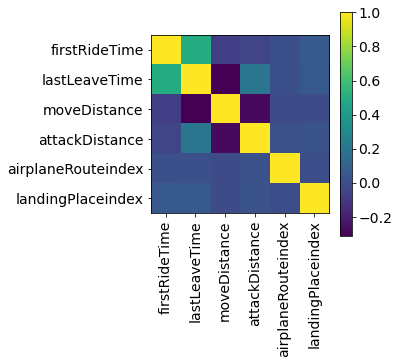

In [72]:
plt.matshow(testDF)
plt.xticks(range(testDF.shape[1]),testDF.columns, fontsize=14, rotation=90)
plt.gca().xaxis.tick_bottom()
plt.yticks(range(testDF.shape[1]),testDF.columns, fontsize=14)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

In [83]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
#매치 정보 훈련 테스트 데이터로 분할
matchTrainDF, matchTestDF = matchInfoDF.randomSplit([0.8,0.2],seed=20)

#1단계 맵, 비행기동선, 착지장소
#착지장소에 비행기 동선 추가
matchTrainDF = matchTrainDF.alias('MI').join(matchPlayerDF.alias('LP'),["matchId","mapName"],'inner')\
                      .select('MI.matchId','MI.mapName','LP.playerName','MI.airplaneRoute','LP.landingPlace','LP.ranking') \
                      .na.drop()
matchTrainDF.printSchema()
matchTrainDF.show(10)

matchTestDF = matchTestDF.alias('MI').join(matchPlayerDF.alias('LP'),["matchId","mapName"],'inner')\
                      .select('MI.matchId','MI.mapName','LP.playerName','MI.airplaneRoute','LP.landingPlace','LP.ranking') \
                      .na.drop()
matchTestDF.printSchema()
matchTestDF.show(10)

root
 |-- matchId: string (nullable = true)
 |-- mapName: string (nullable = true)
 |-- playerName: string (nullable = true)
 |-- airplaneRoute: string (nullable = true)
 |-- landingPlace: string (nullable = true)
 |-- ranking: long (nullable = true)

+--------------------+-----------+-----------+-------------+-------------+-------+
|             matchId|    mapName| playerName|airplaneRoute| landingPlace|ranking|
+--------------------+-----------+-----------+-------------+-------------+-------+
|376564f4-b798-4b8...|Baltic_Main|   mono0000|       Middle|         Farm|      2|
|376564f4-b798-4b8...|Baltic_Main|  MANGO0_0O|       Middle|      another|     12|
|376564f4-b798-4b8...|Baltic_Main|   JB_River|       Middle|      Yasnaya|      4|
|376564f4-b798-4b8...|Baltic_Main| baebaebaby|       Middle|      Severny|     12|
|376564f4-b798-4b8...|Baltic_Main|AFTV_DDOBOM|       Middle| MilitaryBase|     10|
|376564f4-b798-4b8...|Baltic_Main|   1ban_in_|       Middle|       Quarry|     15|
|

In [84]:
#등수 묶기(순위권)
def splitrank(data):
    if data<=3:
        return "HighRank"
    elif data>=10:
        return "MiddleRank"
    else:
        return "LowRank"
    return data

convertUDF = udf(lambda x:splitrank(x),StringType())

matchTrainDF = matchTrainDF.select('matchId','mapName','playerName','airplaneRoute','landingPlace',convertUDF(col('ranking')).alias('ranking'))
matchTrainDF.show(10)

matchTestDF = matchTestDF.select('matchId','mapName','playerName','airplaneRoute','landingPlace',convertUDF(col('ranking')).alias('ranking'))
matchTestDF.show(10)

+--------------------+-----------+-------------+-------------+-------------+----------+
|             matchId|    mapName|   playerName|airplaneRoute| landingPlace|   ranking|
+--------------------+-----------+-------------+-------------+-------------+----------+
|376564f4-b798-4b8...|Baltic_Main|  Happiness45|       Middle|       Quarry|MiddleRank|
|376564f4-b798-4b8...|Baltic_Main|  WWS_Meerkat|       Middle|      Yasnaya|MiddleRank|
|376564f4-b798-4b8...|Baltic_Main|  xoxo_Toreta|       Middle|     Pochinki|MiddleRank|
|376564f4-b798-4b8...|Baltic_Main|   Safe_ChanE|       Middle|      another|MiddleRank|
|376564f4-b798-4b8...|Baltic_Main|BBQ-_-chicken|       Middle|      Yasnaya|  HighRank|
|376564f4-b798-4b8...|Baltic_Main|  WWS_KKANZOC|       Middle|      Yasnaya|MiddleRank|
|376564f4-b798-4b8...|Baltic_Main|    dongtaeng|       Middle|      Severny|MiddleRank|
|376564f4-b798-4b8...|Baltic_Main|     OcO_SEXY|       Middle|MiddleVillage|   LowRank|
|376564f4-b798-4b8...|Baltic_Mai

In [85]:
trainDF = matchTrainDF.select('airplaneRoute','landingPlace','ranking')
testDF = matchTestDF.select('airplaneRoute','landingPlace','ranking')

categoricalCols = ['airplaneRoute','landingPlace']
stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=[x+'index' for x in categoricalCols]\
                             ,handleInvalid="keep")
encoder = OneHotEncoder(inputCols=stringIndexer.getOutputCols(),outputCols=[x+'OHE' for x in categoricalCols])
labelToIndex = StringIndexer(inputCol='ranking',outputCol='label')

In [86]:
stringIndexerModel = stringIndexer.fit(trainDF)
tempIndexerDF = stringIndexerModel.transform(trainDF)
tempIndexerDF.show(5)

+-------------+-------------+----------+------------------+-----------------+
|airplaneRoute| landingPlace|   ranking|airplaneRouteindex|landingPlaceindex|
+-------------+-------------+----------+------------------+-----------------+
|       Middle|      Yasnaya|   LowRank|               0.0|              5.0|
|       Middle|       Quarry|MiddleRank|               0.0|             21.0|
|       Middle|MiddleVillage|   LowRank|               0.0|              1.0|
|       Middle|       School|  HighRank|               0.0|              4.0|
|       Middle|      Yasnaya|   LowRank|               0.0|              5.0|
+-------------+-------------+----------+------------------+-----------------+
only showing top 5 rows



In [87]:
#mapNameIndex = []
airplaneRouteIndex = []
landingPlaceIndex = []

#for i in tempIndexerDF.select('mapName','mapNameindex').distinct().collect():
    #mapNameIndex.append(tuple(i))
for i in tempIndexerDF.select('airplaneRoute','airplaneRouteindex').distinct().collect():
    airplaneRouteIndex.append(tuple(i))
for i in tempIndexerDF.select('landingPlace','landingPlaceindex').distinct().collect():
    landingPlaceIndex.append(tuple(i))
    
#print(mapNameIndex)
print(airplaneRouteIndex)
print(landingPlaceIndex)

[('RightSide_Middle', 1.0), ('Middle', 0.0), ('LeftSide_Middle', 2.0)]
[('Zharki', 30.0), ('TopVillage', 22.0), ('Farm', 11.0), ('Georgopol_south', 3.0), ('Yasnaya', 5.0), ('Ruins', 27.0), ('Ferry Pier', 24.0), ('Prison', 25.0), ('Kameshki', 29.0), ('Stalber', 23.0), ('Georgopol_north', 8.0), ('ShootingRange', 31.0), ('Mansion', 26.0), ('MilitaryBridge', 28.0), ('Pochinki', 2.0), ('School', 4.0), ('Getka', 15.0), ('Rozhok', 14.0), ('another', 0.0), ('Quarry', 21.0), ('Primorsk', 12.0), ('MiddleBridgeVillage', 20.0), ('RightSideVillage', 19.0), ('Mylta', 7.0), ('MilitaryBackYard', 33.0), ('Novorepnoye', 9.0), ('MiddleVillage', 1.0), ('Severny', 10.0), ('Shelter', 17.0), ('SideVillage', 13.0), ('AquaCity', 32.0), ('MilitaryBase', 6.0), ('MyltaPower', 18.0), ('Lipovka', 16.0)]


In [88]:
from pyspark.ml.feature import VectorAssembler
assemblerInputs = [c + "OHE" for c in categoricalCols]
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
tempIndexerDF = stringIndexerModel.transform(trainDF)
tempIndexerDF.show(5)

+-------------+------------+----------+------------------+-----------------+
|airplaneRoute|landingPlace|   ranking|airplaneRouteindex|landingPlaceindex|
+-------------+------------+----------+------------------+-----------------+
|       Middle|        Farm|  HighRank|               0.0|             11.0|
|       Middle|     another|MiddleRank|               0.0|              0.0|
|       Middle|     Yasnaya|   LowRank|               0.0|              5.0|
|       Middle|     Severny|MiddleRank|               0.0|             10.0|
|       Middle|MilitaryBase|MiddleRank|               0.0|              6.0|
+-------------+------------+----------+------------------+-----------------+
only showing top 5 rows



In [89]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='features', labelCol='label')

In [90]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[stringIndexer, encoder, labelToIndex, vecAssembler, lr])
pipelineModel = pipeline.fit(trainDF)
predDF = pipelineModel.transform(testDF) 
predDF.select("features", "label", "prediction", "probability").show(5,truncate=False)

+---------------------+-----+----------+-------------------------------------------------------------+
|features             |label|prediction|probability                                                  |
+---------------------+-----+----------+-------------------------------------------------------------+
|(37,[1,9],[1.0,1.0]) |0.0  |0.0       |[0.4760832874229982,0.35914357180230816,0.16477314077469357] |
|(37,[1,31],[1.0,1.0])|1.0  |1.0       |[0.3214271593785508,0.49548580926500585,0.18308703135644333] |
|(37,[1,5],[1.0,1.0]) |1.0  |0.0       |[0.5110892626666231,0.3108615571167779,0.17804918021659896]  |
|(37,[1,19],[1.0,1.0])|2.0  |0.0       |[0.5275883608200768,0.2959602226740886,0.17645141650583474]  |
|(37,[1,12],[1.0,1.0])|2.0  |0.0       |[0.44010954964022664,0.36606848078288023,0.19382196957689324]|
+---------------------+-----+----------+-------------------------------------------------------------+
only showing top 5 rows



In [91]:
predDF.select("features", "label", "prediction", "probability").show(5,truncate=False)

+---------------------+-----+----------+-------------------------------------------------------------+
|features             |label|prediction|probability                                                  |
+---------------------+-----+----------+-------------------------------------------------------------+
|(37,[1,9],[1.0,1.0]) |0.0  |0.0       |[0.4760832874229982,0.35914357180230816,0.16477314077469357] |
|(37,[1,31],[1.0,1.0])|1.0  |1.0       |[0.3214271593785508,0.49548580926500585,0.18308703135644333] |
|(37,[1,5],[1.0,1.0]) |1.0  |0.0       |[0.5110892626666231,0.3108615571167779,0.17804918021659896]  |
|(37,[1,19],[1.0,1.0])|2.0  |0.0       |[0.5275883608200768,0.2959602226740886,0.17645141650583474]  |
|(37,[1,12],[1.0,1.0])|2.0  |0.0       |[0.44010954964022664,0.36606848078288023,0.19382196957689324]|
+---------------------+-----+----------+-------------------------------------------------------------+
only showing top 5 rows



In [92]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predDF)
print("정확도 = " ,accuracy)

정확도 =  0.4604623389917257
